In [26]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from skimage.color import rgb2lab, rgb2gray
from skimage import img_as_float
from scipy.stats import skew, kurtosis

# Class names and their corresponding labels
class_names = ['anemic', 'Non-anemic']  
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (224, 224)


def load_data():
    """
    Load the dataset and split it into training, validation, and testing sets.
    """
    dataset_dir = '/home/oali/GP/phase 1/Fingernails/Fingernails'
    images = []
    labels = []

    print("Loading dataset...")

    for folder in class_names:
        folder_path = os.path.join(dataset_dir, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder '{folder}' does not exist in dataset directory.")
            continue
        
        label = class_names_label[folder]
        
        for file in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
            img_path = os.path.join(folder_path, file)
            image = cv2.imread(img_path)
            
            if image is None:
                print(f"Warning: Failed to load image {img_path}. Skipping.")
                continue
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)
            
            images.append(image)
            labels.append(label)
    
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    images, labels = shuffle(images, labels, random_state=25)
    
    # Splitting the data into 75% train, 10% validation, and 15% test
    split_1 = int(0.75 * len(images))
    split_2 = int(0.85 * len(images))
    
    train_images, train_labels = images[:split_1], labels[:split_1]
    val_images, val_labels = images[split_1:split_2], labels[split_1:split_2]
    test_images, test_labels = images[split_2:], labels[split_2:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)


def extract_color_features(images):
    """
    Extract color features from a list of images.
    """
    features = []

    for img in images:
        # Normalize the image (if necessary) to the range [0, 1]
        img = img_as_float(img)

        # Convert image to LAB color space
        lab = rgb2lab(img)

        # Extract L, A, B channels
        L, A, B = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

        # Calculate statistical moments (mean, std, skew, kurtosis) for each channel
        l_mean, l_std, l_skew, l_kurt = np.mean(L), np.std(L), skew(L.flatten()), kurtosis(L.flatten())
        a_mean, a_std, a_skew, a_kurt = np.mean(A), np.std(A), skew(A.flatten()), kurtosis(A.flatten())
        b_mean, b_std, b_skew, b_kurt = np.mean(B), np.std(B), skew(B.flatten()), kurtosis(B.flatten())

        # Histograms for each channel (normalized)
        l_hist, _ = np.histogram(L.flatten(), bins=256, range=(0, 100), density=True)
        a_hist, _ = np.histogram(A.flatten(), bins=256, range=(-128, 128), density=True)
        b_hist, _ = np.histogram(B.flatten(), bins=256, range=(-128, 128), density=True)

        # Flatten histograms and concatenate with other features
        hist_features = np.concatenate([l_hist, a_hist, b_hist])

        # Combine all extracted features into a single feature vector
        feature_vector = np.array([l_mean, l_std, l_skew, l_kurt, a_mean, a_std, a_skew, a_kurt, b_mean, b_std, b_skew, b_kurt])
        feature_vector = np.concatenate([feature_vector, hist_features])

        features.append(feature_vector)

    return np.array(features)


# Load the dataset
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_data()

# Preprocess the images
train_images = preprocess_input(train_images)
val_images = preprocess_input(val_images)
test_images = preprocess_input(test_images)

# Extract color features
print("Extracting color features...")
train_features = extract_color_features(train_images)
val_features = extract_color_features(val_images)
test_features = extract_color_features(test_images)

# Dataset Statistics
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print(f"Number of training examples: {n_train}")
print(f"Number of validation examples: {n_val}")
print(f"Number of testing examples: {n_test}")
print(f"Each image is of size: {IMAGE_SIZE}")
print(f"Feature vector length: {train_features.shape[1]}")


Loading dataset...


Processing Non-anemic: 100%|██████████| 1695/1695 [00:00<00:00, 4276.23it/s]


Extracting color features...


/home/oali/.local/lib/python3.10/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Number of training examples: 3195
Number of validation examples: 426
Number of testing examples: 639
Each image is of size: (224, 224)
Feature vector length: 780


Validation Accuracy: 99.06%
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       265
           1       0.99      0.98      0.99       161

    accuracy                           0.99       426
   macro avg       0.99      0.99      0.99       426
weighted avg       0.99      0.99      0.99       426

Test Accuracy: 99.22%
Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       392
           1       1.00      0.98      0.99       247

    accuracy                           0.99       639
   macro avg       0.99      0.99      0.99       639
weighted avg       0.99      0.99      0.99       639



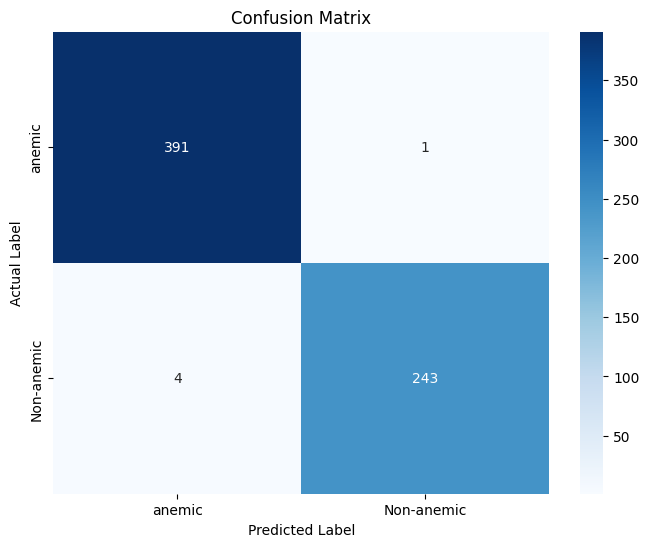

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Initialize and Train the Model
classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=9)
classifier.fit(train_features, train_labels)

# Step 2: Evaluate on Validation Set
val_predictions = classifier.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)

print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))
print("Validation Classification Report:\n", classification_report(val_labels, val_predictions))

# Step 3: Evaluate on Test Set
test_predictions = classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Classification Report:\n", classification_report(test_labels, test_predictions))

# Step 4: Plot Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


In [28]:
from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross-Validation
cv_scores = cross_val_score(classifier, train_features, train_labels, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy: {:.2f}%".format(np.mean(cv_scores) * 100))
print("Standard Deviation of CV Accuracy: {:.2f}%".format(np.std(cv_scores) * 100))


Cross-Validation Accuracy Scores: [0.98122066 0.9827856  0.99061033 0.9827856  0.99374022]
Mean Cross-Validation Accuracy: 98.62%
Standard Deviation of CV Accuracy: 0.50%
